# 여드름 종류 진단 AI

### 라이브러리 Import

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 설정 및 경로 지정

In [2]:
# 라벨 정의 (순서대로 정상, 좁쌀, 화농성, 염증성, 모낭염)
# labels = ['normal', 'comedones', 'pustules', 'papules', 'folliculitis']
labels = ['comedones', 'pustules', 'papules', 'folliculitis']

# 데이터 경로
data_dir = '/Users/jeongjin/Desktop/Git/AcneLog_AI/data'

# 이미지 크기
image_size = (224, 224)

# 하이퍼파라미터
BATCH_SIZE = 32
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10
INITIAL_LR = 0.001
FINE_TUNE_LR = 1e-5

labels

['comedones', 'pustules', 'papules', 'folliculitis']

### 데이터 로드 및 전처리

In [3]:
def load_images_and_labels(data_dir, labels, image_size=(224, 224)):
    """
    이미지 데이터를 로드하고 전처리하는 함수
    
    Args:
        data_dir: 데이터 디렉토리 경로
        labels: 클래스 라벨 리스트
        image_size: 리사이즈할 이미지 크기
    
    Returns:
        images: numpy array of images
        targets: numpy array of labels
    """
    image_dir = os.path.join(data_dir, 'image')
    images, targets = [], []
    
    for idx, label in enumerate(labels):
        folder_path = os.path.join(image_dir, label)
        print(f"Loading {label}...", end=' ')
        
        file_count = 0
        for file in os.listdir(folder_path):
            if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"\n  Warning: Failed to load {img_path}")
                continue
            
            # BGR to RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # 리사이즈
            img = cv2.resize(img, image_size)
            # 정규화 [0, 1]
            img = img / 255.0
            
            images.append(img)
            targets.append(idx)
            file_count += 1
        
        print(f"→ {file_count} images loaded")
    
    return np.array(images, dtype=np.float32), np.array(targets)

### 데이터 로드 및 확인

In [4]:
# 데이터 로드
X, y = load_images_and_labels(data_dir, labels, image_size)

print(f"\n{'='*50}")
print(f"전체 데이터: {len(X)} images")
print(f"이미지 shape: {X.shape}")
print(f"\n클래스별 분포:")
for idx, label in enumerate(labels):
    count = np.sum(y == idx)
    print(f"  {label}: {count} images ({count/len(y)*100:.1f}%)")
print(f"{'='*50}")

Loading comedones... → 257 images loaded
Loading pustules... → 503 images loaded
Loading papules... 

libpng warning: iCCP: known incorrect sRGB profile


→ 1297 images loaded
Loading folliculitis... → 171 images loaded

전체 데이터: 2228 images
이미지 shape: (2228, 224, 224, 3)

클래스별 분포:
  comedones: 257 images (11.5%)
  pustules: 503 images (22.6%)
  papules: 1297 images (58.2%)
  folliculitis: 171 images (7.7%)


### 샘플 이미지 시각화

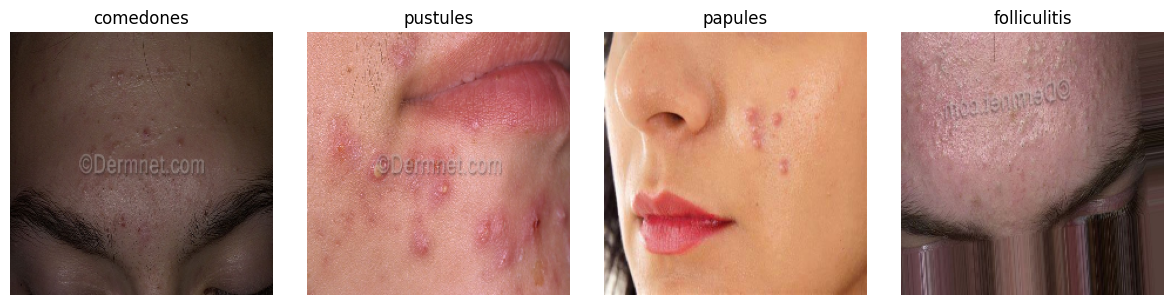

In [5]:
# 각 클래스별로 샘플 이미지 표시
plt.figure(figsize=(15, 3))
for idx, label in enumerate(labels):
    # 해당 클래스의 첫 번째 이미지 찾기
    sample_idx = np.where(y == idx)[0][0]
    plt.subplot(1, 5, idx + 1)
    plt.imshow(X[sample_idx])
    plt.title(f"{label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# ========================================================================
# 데이터 리샘플링 (클래스 균형 맞추기)
# ========================================================================

from sklearn.utils import resample

print("=" * 70)
print("데이터 리샘플링")
print("=" * 70)

# 목표: 모든 클래스를 350장으로
TARGET_SAMPLES = 350

X_resampled = []
y_resampled = []

for idx, label in enumerate(labels):
    class_indices = np.where(y == idx)[0]
    n_samples = len(class_indices)
    
    # 많으면 줄이고, 적으면 늘리기
    sampled_indices = resample(
        class_indices,
        n_samples=TARGET_SAMPLES,
        replace=(n_samples < TARGET_SAMPLES),  # 적으면 중복 허용
        random_state=42
    )
    
    action = "언더샘플링" if n_samples > TARGET_SAMPLES else "오버샘플링"
    print(f"  {label:15s}: {n_samples:4d} → {TARGET_SAMPLES} ({action})")
    
    X_resampled.append(X[sampled_indices])
    y_resampled.append(y[sampled_indices])

# 합치고 섞기
X = np.vstack(X_resampled)
y = np.hstack(y_resampled)

shuffle_idx = np.random.RandomState(42).permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]

print(f"\n✅ 리샘플링 완료: {len(X)} images (균형잡힘!)")
print("=" * 70)

데이터 리샘플링
  comedones      :  257 → 350 (오버샘플링)
  pustules       :  503 → 350 (언더샘플링)
  papules        : 1297 → 350 (언더샘플링)
  folliculitis   :  171 → 350 (오버샘플링)

✅ 리샘플링 완료: 1400 images (균형잡힘!)


### Train/Validation 분할

In [7]:
# Train/Val 분할 (80:20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"학습 데이터: {len(X_train)} images")
print(f"검증 데이터: {len(X_val)} images")


학습 데이터: 1120 images
검증 데이터: 280 images


In [8]:
# One-hot encoding만 (가중치 필요 없음!)
num_classes = len(labels)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

print("✅ One-hot encoding 완료!")

✅ One-hot encoding 완료!


### 데이터 증강 (Data Augmentation)

In [9]:
# 데이터 증강 (보수적으로)
datagen = ImageDataGenerator(
    rotation_range=15,           # 회전 각도
    width_shift_range=0.1,       # 가로 이동
    height_shift_range=0.1,      # 세로 이동
    horizontal_flip=True,        # 좌우 반전
    zoom_range=0.1,              # 줌
    fill_mode='nearest'          # 빈 공간 채우기
)

print("데이터 증강 설정 완료")

데이터 증강 설정 완료


### 모델 구성

In [10]:
# EfficientNetB0 base model
base_model = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Transfer Learning: 처음엔 base model 동결
base_model.trainable = False

# Custom head 추가
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)  # ✅ 5개 클래스

# 최종 모델
model = Model(inputs=base_model.input, outputs=outputs)

print("모델 구축 완료")
print(f"\n출력 레이어: {num_classes} classes")
print(f"Base model layers: {len(base_model.layers)}")
print(f"Total model layers: {len(model.layers)}")

모델 구축 완료

출력 레이어: 4 classes
Base model layers: 238
Total model layers: 244


In [11]:
model.summary() # 모델 구조 확인

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,410,919 (16.83 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 모델 학습 Phase1: Head 학습 (Base Model 동결)

In [12]:
# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("=" * 60)
print("Phase 1: Training head only (base model frozen)")
print("=" * 60)

history1 = model.fit(
    X_train, y_train,  # 🔥 datagen 대신 직접 사용
    validation_data=(X_val, y_val),
#    sample_weight=sample_weights_train,  # 🔥 sample_weight 사용!
    epochs=EPOCHS_PHASE1,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_phase1,
    verbose=1
)

Phase 1: Training head only (base model frozen)
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.2428 - loss: 1.4690 - val_accuracy: 0.2500 - val_loss: 1.3905 - learning_rate: 0.0010
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 341ms/step - accuracy: 0.2217 - loss: 1.4094 - val_accuracy: 0.2500 - val_loss: 1.3881 - learning_rate: 0.0010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 351ms/step - accuracy: 0.2390 - loss: 1.3989 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 351ms/step - accuracy: 0.2760 - loss: 1.3917 - val_accuracy: 0.2500 - val_loss: 1.3867 - learning_rate: 0.0010
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.2708 - loss: 1.3843 - val_accuracy: 0.2500 - val_loss: 1.3865 - learning_rate: 0.0010
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2609 - loss: 1.3879
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 ━━━━━━━━━━━━━━━━━━━

### Phase 1 결과 시각화

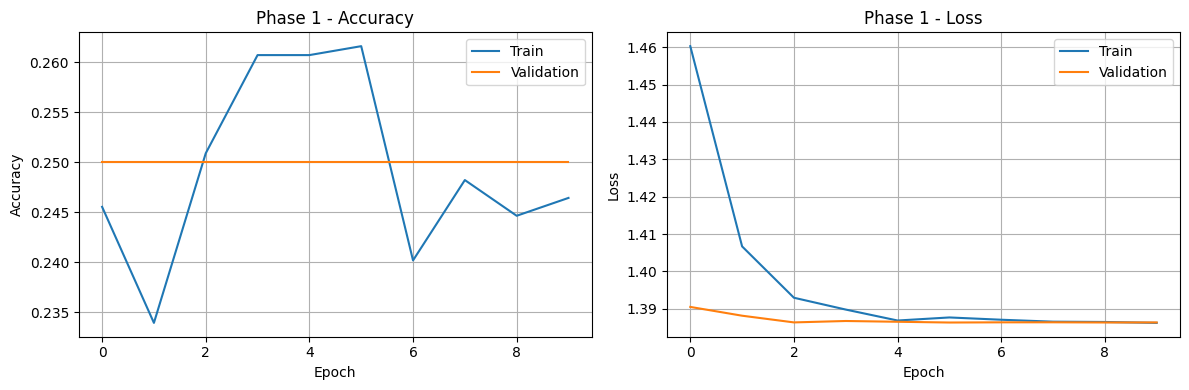


Phase 1 Best Validation Accuracy: 0.2500


In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.title('Phase 1 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.title('Phase 1 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 최고 성능 출력
best_val_acc_phase1 = max(history1.history['val_accuracy'])
print(f"\nPhase 1 Best Validation Accuracy: {best_val_acc_phase1:.4f}")

### 모델 학습 Phase 2: Fine-tuning

In [14]:
# Base model의 일부 레이어만 학습 가능하게 설정
base_model.trainable = True

# 마지막 30%만 학습
fine_tune_at = int(len(base_model.layers) * 0.7)

print(f"Total base model layers: {len(base_model.layers)}")
print(f"Freezing layers: 0 - {fine_tune_at-1}")
print(f"Training layers: {fine_tune_at} - {len(base_model.layers)-1}")

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 낮은 learning rate로 재컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel recompiled for fine-tuning")

Total base model layers: 238
Freezing layers: 0 - 165
Training layers: 166 - 237

Model recompiled for fine-tuning


In [15]:
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

print("=" * 60)
print("Phase 2: Fine-tuning (last 30% layers unfrozen)")
print("=" * 60)

history2 = model.fit(
    X_train, y_train,  # 🔥 datagen 대신 직접 사용
    validation_data=(X_val, y_val),
    # sample_weight=sample_weights_train,  # 🔥 sample_weight 사용!
    epochs=EPOCHS_PHASE2,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_phase2,
    verbose=1
)

Phase 2: Fine-tuning (last 30% layers unfrozen)
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 463ms/step - accuracy: 0.2438 - loss: 1.6126 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 1.0000e-05
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 433ms/step - accuracy: 0.2396 - loss: 1.5830 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 1.0000e-05
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.2394 - loss: 1.5306 - val_accuracy: 0.2500 - val_loss: 1.3863 - learning_rate: 1.0000e-05
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.2620 - loss: 1.4964
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 444ms/step - accuracy: 0.2616 - loss: 1.4964 - val_accuracy: 0.2500 - val_loss: 1.3864 - learning_rate: 1.0000e-05
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 443ms/step - accuracy: 0.2420 - loss: 1.4537 - val_accuracy: 0.2500 - val_loss: 1.3864 - learning_rate: 5.0000e-06
Epoch 6/10
35/35

### Phase 2 결과 시각화

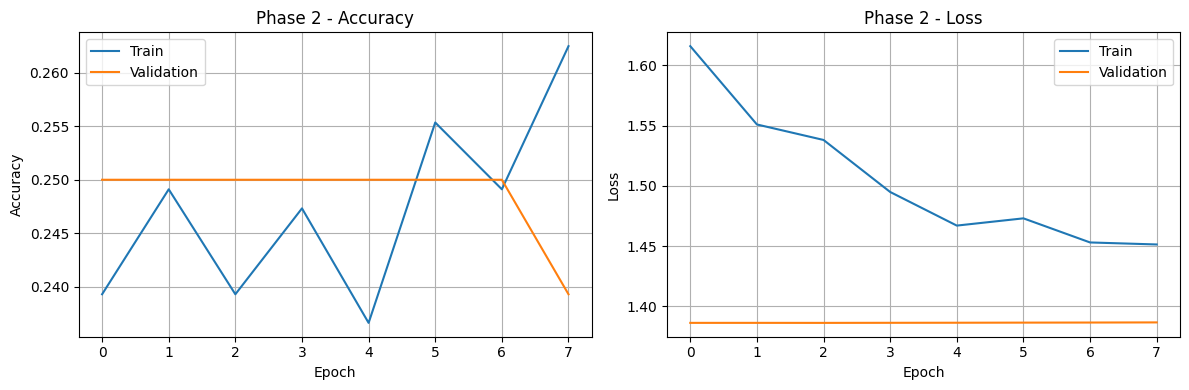


Phase 2 Best Validation Accuracy: 0.2500


In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.title('Phase 2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.title('Phase 2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

best_val_acc_phase2 = max(history2.history['val_accuracy'])
print(f"\nPhase 2 Best Validation Accuracy: {best_val_acc_phase2:.4f}")

### 전체 학습 과정 시각화

학습 곡선 저장: training_curves.png


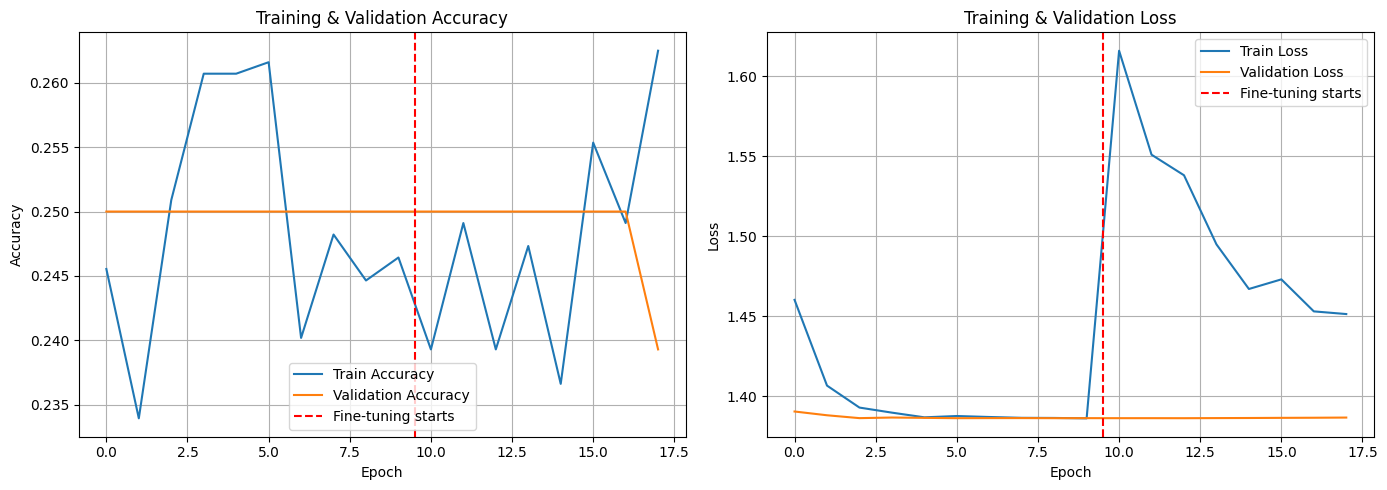

In [17]:
# 두 phase 합치기
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs_range = range(len(acc))
phase1_end = len(history1.history['accuracy'])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x=phase1_end-0.5, color='r', linestyle='--', label='Fine-tuning starts')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x=phase1_end-0.5, color='r', linestyle='--', label='Fine-tuning starts')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
print("학습 곡선 저장: training_curves.png")
plt.show()

### 모델 평가

In [18]:
# 최종 평가
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)

print("=" * 60)
print("최종 평가 결과")
print("=" * 60)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("=" * 60)

최종 평가 결과
Validation Loss: 1.3863
Validation Accuracy: 0.2500


### 예측 및 Classification Report

In [19]:
# 예측
y_pred = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Classification Report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))


Classification Report:
              precision    recall  f1-score   support

   comedones       0.00      0.00      0.00        70
    pustules       0.00      0.00      0.00        70
     papules       0.00      0.00      0.00        70
folliculitis       0.25      1.00      0.40        70

    accuracy                           0.25       280
   macro avg       0.06      0.25      0.10       280
weighted avg       0.06      0.25      0.10       280



/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeongjin/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

### Confusion Matrix 시각화

Confusion Matrix 저장: confusion_matrix.png


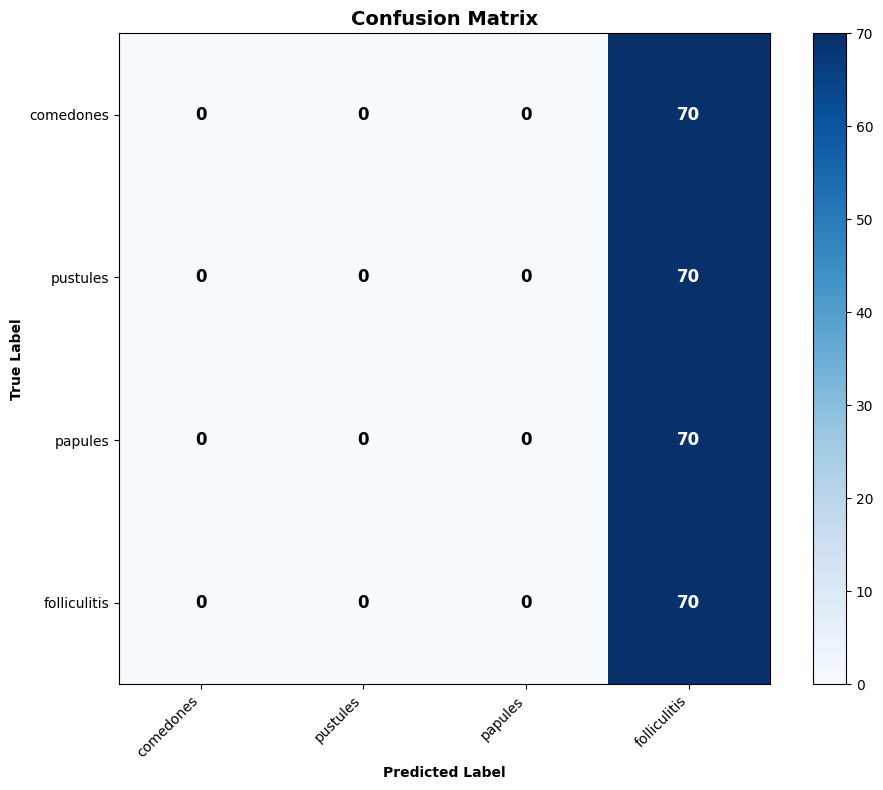

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.colorbar()

tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45, ha='right')
plt.yticks(tick_marks, labels)

# 숫자 표시
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight='bold')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("Confusion Matrix 저장: confusion_matrix.png")
plt.show()

### 클래스별 정확도 분석


클래스별 정확도:
comedones      : 0.0000 (0.00%)
pustules       : 0.0000 (0.00%)
papules        : 0.0000 (0.00%)
folliculitis   : 1.0000 (100.00%)

클래스별 정확도 그래프 저장: class_accuracy.png


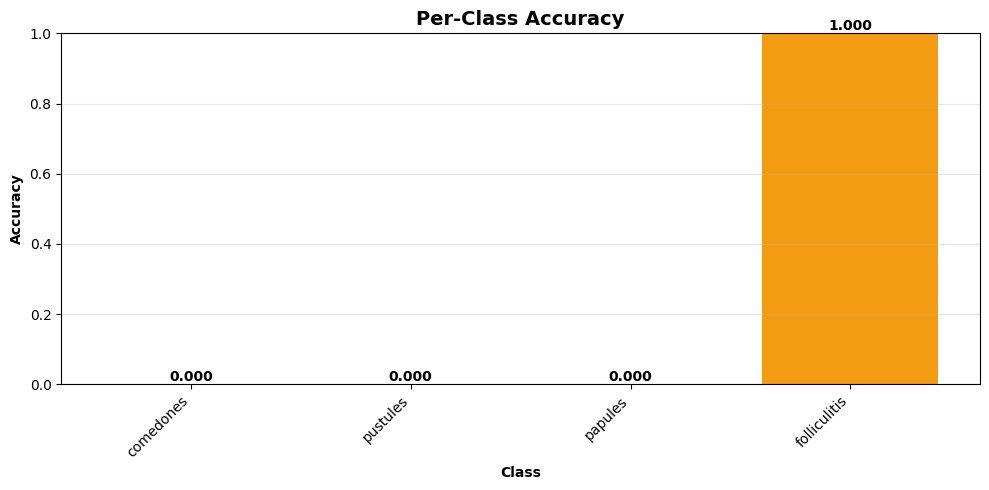

In [21]:
# 클래스별 정확도
class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\n클래스별 정확도:")
print("=" * 60)
for label, acc in zip(labels, class_accuracy):
    print(f"{label:15s}: {acc:.4f} ({acc*100:.2f}%)")
print("=" * 60)

# 시각화
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, class_accuracy, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xlabel('Class', fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# 막대 위에 수치 표시
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}',
            ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('class_accuracy.png', dpi=150, bbox_inches='tight')
print("\n클래스별 정확도 그래프 저장: class_accuracy.png")
plt.show()

### 예측 샘플 시각화

예측 샘플 저장: prediction_samples.png


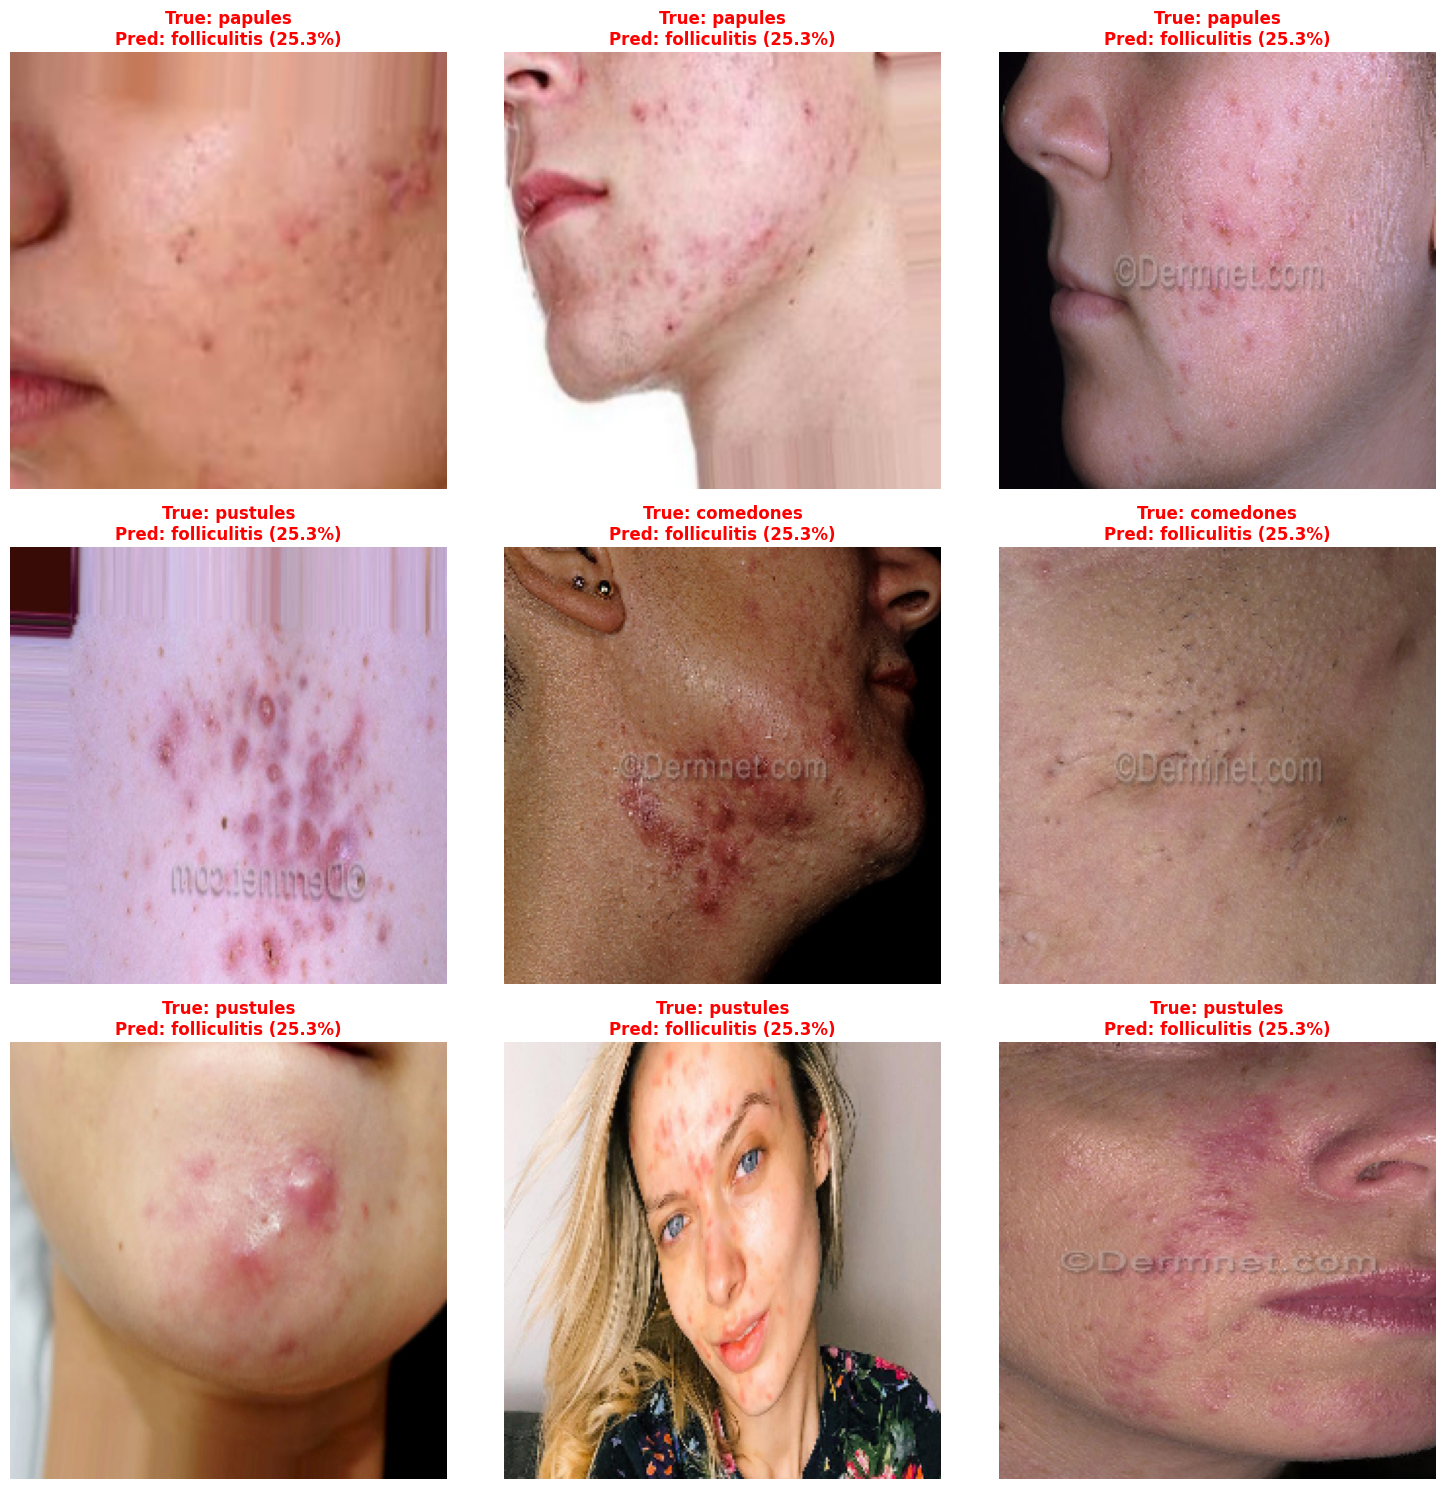

In [22]:
# 랜덤으로 9개 샘플 선택
sample_indices = np.random.choice(len(X_val), 9, replace=False)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_val[idx])
    
    true_label = labels[y_true_classes[idx]]
    pred_label = labels[y_pred_classes[idx]]
    confidence = y_pred[idx][y_pred_classes[idx]] * 100
    
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)",
             color=color, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.savefig('prediction_samples.png', dpi=150, bbox_inches='tight')
print("예측 샘플 저장: prediction_samples.png")
plt.show()

### 모델 저장

In [23]:
# 모델 저장
model_path = "acne_classifier.keras"
model.save(model_path)
print(f"✅ 모델 저장 완료: {model_path}")

# 모델 정보 저장
model_info = {
    'labels': labels,
    'num_classes': num_classes,
    'image_size': image_size,
    'final_val_accuracy': float(val_acc),
    'final_val_loss': float(val_loss),
    'best_phase1_val_acc': float(best_val_acc_phase1),
    'best_phase2_val_acc': float(best_val_acc_phase2)
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
print("✅ 모델 정보 저장 완료: model_info.json")

✅ 모델 저장 완료: acne_classifier.keras
✅ 모델 정보 저장 완료: model_info.json


### 최종 요약

In [24]:
print("\n" + "=" * 70)
print(" " * 20 + "최종 학습 결과 요약")
print("=" * 70)
print(f"\n📊 데이터셋:")
print(f"  - 전체 이미지: {len(X)}")
print(f"  - 학습 데이터: {len(X_train)}")
print(f"  - 검증 데이터: {len(X_val)}")
print(f"  - 클래스 수: {num_classes}")

print(f"\n🎯 모델 성능:")
print(f"  - Phase 1 최고 Validation Accuracy: {best_val_acc_phase1:.4f}")
print(f"  - Phase 2 최고 Validation Accuracy: {best_val_acc_phase2:.4f}")
print(f"  - 최종 Validation Accuracy: {val_acc:.4f}")
print(f"  - 최종 Validation Loss: {val_loss:.4f}")

print(f"\n📁 저장된 파일:")
print(f"  - {model_path}")
print(f"  - model_info.json")
print(f"  - training_curves.png")
print(f"  - confusion_matrix.png")
print(f"  - class_accuracy.png")
print(f"  - prediction_samples.png")

print("\n" + "=" * 70)
print("✅ 모든 작업이 완료되었습니다!")
print("=" * 70)


                    최종 학습 결과 요약

📊 데이터셋:
  - 전체 이미지: 1400
  - 학습 데이터: 1120
  - 검증 데이터: 280
  - 클래스 수: 4

🎯 모델 성능:
  - Phase 1 최고 Validation Accuracy: 0.2500
  - Phase 2 최고 Validation Accuracy: 0.2500
  - 최종 Validation Accuracy: 0.2500
  - 최종 Validation Loss: 1.3863

📁 저장된 파일:
  - acne_classifier.keras
  - model_info.json
  - training_curves.png
  - confusion_matrix.png
  - class_accuracy.png
  - prediction_samples.png

✅ 모든 작업이 완료되었습니다!
